# **News Article Enrichment**

*Arya Zeynep Mete*

**Goal:**

The goal of this project is to solve a real-life problem using transformer models. First, I trained a BERT model to find the category of each news article. Then, I used Google Gemini API to create a clear title and rewrite the article in a better way. At the end, I combined all results to give a full and polished output for each article.

In [1]:
# Connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## **Loading Data and Necessary Libraries**

In [4]:
!pip install google-generativeai
import google.generativeai as genai
import re
import time
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import random
import os

In [6]:
# Load train and test data
train_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ASS5/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ASS5/test.csv')

# Display the first few rows
print(train_df.head())


                                                text  label
0  U.S. Strikes Zarqawi Network, Killing 15 BAGHD...      0
1  MGM shares jump 7.5 pct; report suggests deal ...      2
2  Logitech launches laser-tracking mouse SAN FRA...      3
3  Orb Unveils New Service for Digital Media (AP)...      3
4  Norwegian police hunt for motive, robbers in M...      0


> ## **Basic Exploratory Data Analysis (EDA)**

In [7]:
# General info
print(train_df.info())

# Check for missing values
print(train_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB
None
text     0
label    0
dtype: int64


>> There are 30.000 entries in the training data with 2 columns.

>> All values are non-null so we don't have to handle missing data.

**Label Distribution (Class Balance)**

Label distribution in train set:
 label
0    7500
1    7500
2    7500
3    7500
Name: count, dtype: int64


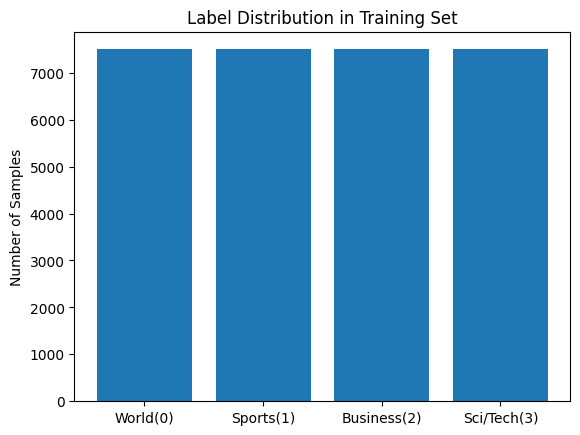

In [8]:
# Count of each label
label_counts = train_df['label'].value_counts().sort_index()
print("Label distribution in train set:\n", label_counts)

# Visualize with bar chart
import matplotlib.pyplot as plt

label_names = ['World(0)', 'Sports(1)', 'Business(2)', 'Sci/Tech(3)'] # I found this label names from original Hugging Face page
plt.bar(label_names, label_counts)
plt.title("Label Distribution in Training Set")
plt.ylabel("Number of Samples")
plt.show()


>> There are equal numbers of examples of each content type, there is an equal distribution.

>> Class distribution is balanced.

**Text Length Analysis**

Text length statistics:
count    30000.000000
mean        49.099733
std         10.475755
min         15.000000
25%         43.000000
50%         47.000000
75%         51.000000
max        177.000000
Name: text_length, dtype: float64


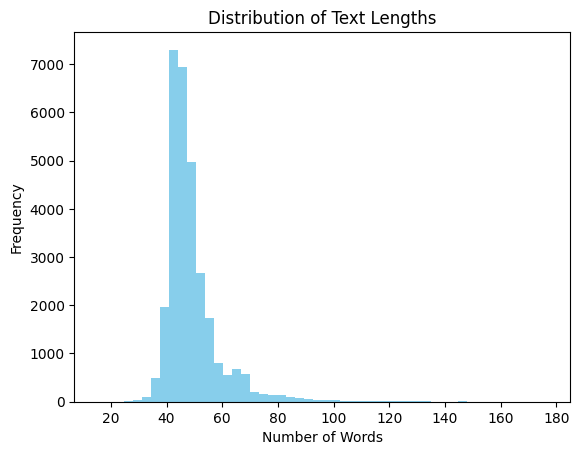

In [9]:
# Add a column for text length
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))

# Basic statistics
print("Text length statistics:")
print(train_df['text_length'].describe())

# Histogram plot
plt.hist(train_df['text_length'], bins=50, color='skyblue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


>> The average text length is approximately 49 words, with a range from 15 to 177.

**Check Example per Class**

In [ ]:
# Show one example from each class
for label in sorted(train_df['label'].unique()):
    example = train_df[train_df['label'] == label].iloc[0]
    print(f"\nLabel {label} ({label_names[label]}):\n{example['text'][:300]}...")



Label 0 (World(0)):
U.S. Strikes Zarqawi Network, Killing 15 BAGHDAD, Iraq - U.S. warplanes, tanks and artillery repeatedly hit at Abu Musab al-Zarqawi's terror network in the insurgent stronghold of Fallujah on Saturday, while two British Muslim leaders came to Baghdad to try to convince his followers to release a Bri...

Label 1 (Sports(1)):
Costantino leads R.I. to win SOUTH WILLIAMSPORT, Pa. -- Chris Costantino struck out Jacob Maxwell with the bases loaded to end the game as Lincoln, R.I., held on to beat Davenport, Iowa, 3-2, last night in Little League World Series action. Costantino finished with 15 strikeouts and allowed just fou...

Label 2 (Business(2)):
MGM shares jump 7.5 pct; report suggests deal near Metro-Goldwyn-Mayer Inc. (MGM.N: Quote, Profile, Research) shares jumped more than 7 percent on Wednesday on a report that a deal to acquire the company for up to \$5 billion could be announced as early as next week....

Label 3 (Sci/Tech(3)):
Logitech launches laser-tracki

## **Preprocessing**

When using transformer models like BERT, heavy preprocessing (like removing stopwords, stemming, or lemmatization) is **not recommended** because:

BERT is trained on raw, unprocessed text.

It uses its own tokenizer which handles punctuation, casing, and unknown words effectively.

Since I am using BERT Base Uncased, I will apply minimal preprocessing to avoid interfering with the BERT tokenizer's expectations.



Trim leading/trailing whitespace

In [10]:
train_df['text'] = train_df['text'].str.strip()

## **Train and Validation Split**

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_df.index.values,
                                                  train_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=train_df.label.values)

train_df['data_type'] = ['not_set']*train_df.shape[0]

train_df.loc[X_train, 'data_type'] = 'train'
train_df.loc[X_val, 'data_type'] = 'val'

train_df.groupby(['label', 'data_type']).count()

text  text_length
label data_type                   
0     train      6375         6375
      val        1125         1125
1     train      6375         6375
      val        1125         1125
2     train      6375         6375
      val        1125         1125
3     train      6375         6375
      val        1125         1125

# **Part 1: Category Classificataion**

## **Encoding Data with BertTokenizer**

Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.

Constructs a BERT tokenizer. Based on WordPiece.

Instantiate a pre-trained BERT model configuration to encode our data.

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', # model trained on lowercase data, so this param makes input text lowercase
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus( #to convert all the texts into encoded form
    train_df[train_df.data_type=='train'].text.values,  # text values
    add_special_tokens=True, # sequences will be encoded with the special tokens (like [CLS] and [SEP]) relative to their model
    return_attention_mask=True, # a mask is returned showing which tokens are real and which are padding
    padding='max_length', # pads all sentences up to 256 tokens long (padding is done with 0 for short sentences).
    max_length=256, # each sentence sets a limit of 256 tokens maximum
    truncation=True,
    return_tensors='pt' # returns as a PyTorch tensor (because the model works with PyTorch)
)

encoded_data_val = tokenizer.batch_encode_plus(
    train_df[train_df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

# Preparing for TensorDataset (Structure Understood by the Model)
# we need to split the data into input_ids, attention_masks and labels
input_ids_train = encoded_data_train['input_ids'] # equivalent of each word in the BERT dictionary (example: "apple" → 1243)
attention_masks_train = encoded_data_train['attention_mask'] # places with 1 are real tokens, places with 0 are padding.
labels_train = torch.tensor(train_df[train_df.data_type=='train'].label.values) # labels: real class labels (0-3)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_df[train_df.data_type=='val'].label.values)

# Creating a TensorDataset
# Creates data in a format that can be easily used with PyTorch DataLoader.
# BERT is given both input_ids, attention_mask, and label at the same time.

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **BERT Pre-trained Model**

We are treating each text as its unique sequence, so one sequence will be classified to one of the four labels.

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # specialized version of Hugging Face's BERT model for classification
                                                      num_labels=len(label_names), # to indicate the number of output labels, classification head with num_labels neurons in its last layer
                                                      output_attentions=False, # don’t need
                                                      output_hidden_states=False) # model's middleware outputs (for visualization/analysis) are not returned — they are not needed for training

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## **Data Loaders**
DataLoader: Divides the data into small pieces (mini-batches) and enables the model to use it easily.

In [14]:
batch_size = 8 #samples at a time will be used for training

# RandomSampler for training and SequentialSampler for validation

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train), # Samples are taken randomly in training → reduces overfitting
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val), # During verification, samples are taken sequentially → gives deterministic (same output for same input) results
                                   batch_size=batch_size)                   # allows the model to be tested under the same conditions

## **Optimizer & Scheduler**
- optimizer = Learning Mechanism

When the model makes a mistake, it needs to change its weights. The optimizer determines how to update these weights.

To construct an optimizer, we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, epsilon, etc.

I found epochs=3 works well for this data set.

- scheduler = Learning Rate Scheduler

Large models like BERT must learn fast at first, then slowly.

For the first few steps, lr may remain constant (warmup). Then it applies a slowly decreasing learning rate.

In [16]:
optimizer = AdamW(model.parameters(), # specific optimization algorithm proposed for BERT
                  lr=1e-5, # learning rate — quite low (suitable for large models like BERT)
                  eps=1e-8) # increases numerical stability (prevents division by zero etc.).

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, # for BERT models, the linear learning rate decay strategy is very effective
                                            num_warmup_steps=0, # start learning right away (in some scenarios a small "warm-up" period may be given)
                                            num_training_steps=len(dataloader_train)*epochs) # calculates the total number of steps to be trained

## **Performance Metrics**
We will use f1 score and accuracy per class as performance metrics.

In [15]:
label_names = ['World(0)', 'Sports(1)', 'Business(2)', 'Sci/Tech(3)']

label_dict = {}
for label in label_names:
    name = label.split('(')[0]  # Gets before parentheses
    index = int(label.split('(')[1].replace(')', ''))  # Gets the number in parentheses
    label_dict[name] = index

print(label_dict)

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


In [17]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## **Training Loop**

In [19]:
# Seed Tuning (For Deterministic Training)
# Ensures that getting the same results every run. Controls randomness in training.
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val): # tests the trained model on validation data

    model.eval() # puts the model in test mode (Dropout etc. is turned off)

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch) # takes the batches in order and sends them to the GPU/CPU

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad(): # since no training will be performed, memory usage is reduced
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train() # pass to training mode

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0], # prepare input
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs) # run model

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # limit gradients (for stability)

        optimizer.step() # update weights
        scheduler.step() # update learning rate

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # At the end of each epoch the model is saved to the file
    os.makedirs("data_volume", exist_ok=True)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation) # model is evaluated with validation data
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.24809895360426348
Validation loss: 0.25143673684266865
F1 Score (Weighted): 0.9404782451532281


Epoch 2:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1461703652893627
Validation loss: 0.2638784379652432
F1 Score (Weighted): 0.94237219510729


Epoch 3:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.08972360050805675
Validation loss: 0.29651724578554556
F1 Score (Weighted): 0.9422150917408793


**Training and Validation Results Summary**

The training process was run for *3 epochs*. At each epoch, the model's performance improved on the training set, as shown by the decreasing training loss (from 0.248 to 0.089). However, the validation loss slightly increased over time (from 0.251 to 0.296), which may indicate a small amount of overfitting. Despite this, the F1 Score remained high and stable across *all epochs (around 0.94), showing that the model made accurate predictions overall*.

## **Experiment 1: Using Weighted Loss Function (Class Weighting)**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Seed Tuning
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Class Weight Calculation
train_labels = [label for batch in dataloader_train for label in batch[2].cpu().numpy()] # get labels from training dataset

# Calculating class wights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Evaluation Function
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs[1]
        loss = loss_fn(logits, inputs['labels'])
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Training Loop
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        logits = outputs[1]
        loss = loss_fn(logits, inputs['labels'])
        loss_train_total += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': f'{loss.item() / len(batch):.3f}'})

    os.makedirs("data_volume", exist_ok=True)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.anotherModel')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg:.4f}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss:.4f}')
    tqdm.write(f'F1 Score (Weighted): {val_f1:.4f}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2935
Validation loss: 0.2488
F1 Score (Weighted): 0.9383


Epoch 2:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1564
Validation loss: 0.2709
F1 Score (Weighted): 0.9416


Epoch 3:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1002
Validation loss: 0.2837
F1 Score (Weighted): 0.9422


> As an experiment, I *modified the loss function by applying class weights to handle potential class imbalance in the training data*. Specifically, I used compute_class_weight from sklearn to *calculate balanced weights for each class based on their frequency*. These weights were then passed to the *CrossEntropyLoss* function.

> The reason for this change was to *give more importance to minority classes during training*, aiming to improve the model's performance on less frequent labels. This is a common technique used when the dataset has unbalanced class distributions.

**Why I Expected It to Help**

In many real-world classification problems, some classes appear more frequently than others. Without weighting, the model may become biased toward majority classes and underperform on minority classes. Using a weighted loss function helps the model pay more attention to the underrepresented labels, which can improve overall performance metrics like F1 score.

**Results**

| Epoch | Model Type          | Training Loss | Validation Loss | F1 Score (Weighted) |
|-------|---------------------|----------------|------------------|----------------------|
| 1     | With Class Weights  | 0.2935         | 0.2488           | 0.9383               |
| 2     | With Class Weights  | 0.1564         | 0.2709           | 0.9416               |
| 3     | With Class Weights  | 0.1002         | 0.2837           | 0.9422               |
| 1     | Original Model      | 0.2481         | 0.2514           | 0.9405               |
| 2     | Original Model      | 0.1462         | 0.2638           | 0.9424               |
| 3     | Original Model      | 0.0897         | 0.2965           | 0.9422               |

**Conclusion**

Although the weighted loss function slightly changed the training dynamics, the *F1 scores of both models were already high and remained close*. There was no meaningful performance improvement, likely because the original model was already performing very well.

> Additionally, the effect of this change may have been limited because the classes in the dataset appear to be **relatively balanced**.


# **Experiment 2: With Different Parameters**

In [20]:
optimizer = AdamW(model.parameters(), # specific optimization algorithm proposed for BERT
                  lr=2e-5, # learning rate — slightly increased
                  eps=1e-8, # increases numerical stability (prevents division by zero etc.).
                  weight_decay=0.01) # Add weight decay for regularization

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, # for BERT models, the linear learning rate decay strategy is very effective
                                            num_warmup_steps=0, # start learning right away (in some scenarios a small "warm-up" period may be given)
                                            num_training_steps=len(dataloader_train)*epochs) # calculates the total number of steps to be trained

In [22]:
for epoch in tqdm(range(1, epochs+1)):
    t0_epoch = time.time()

    model.train() # pass to training mode

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0], # prepare input
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs) # run model

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # limit gradients (for stability)

        optimizer.step() # update weights
        scheduler.step() # update learning rate

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # At the end of each epoch the model is saved to the file
    os.makedirs("data_volume", exist_ok=True)
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.DifferentParametersModel')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation) # model is evaluated with validation data
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Epoch time: {time.time() - t0_epoch:.2f}s')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.25880451892119766
Validation loss: 0.2558764461081576
F1 Score (Weighted): 0.9385674235904007
Epoch time: 1245.99s


Epoch 2:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.14992997565678756
Validation loss: 0.24720798548549616
F1 Score (Weighted): 0.94363889730098
Epoch time: 1246.52s


Epoch 3:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.08200619685437598
Validation loss: 0.2894820886442247
F1 Score (Weighted): 0.9469979996009942
Epoch time: 1247.66s


Epoch 4:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.03810600603310548
Validation loss: 0.37720024586840795
F1 Score (Weighted): 0.9391938586417188
Epoch time: 1244.30s


Epoch 5:   0%|          | 0/3188 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.016854406933853306
Validation loss: 0.3973225685901944
F1 Score (Weighted): 0.9420326825059252
Epoch time: 1249.00s


## Experiment with Different Parameters

In this experiment, I changed the hyperparameters of the BERT model training to see if I could improve the model's performance. I made two main changes:

1.  **Increased the learning rate:** I changed the learning rate from 1e-5 to 2e-5.
2.  **Added weight decay:** I added weight_decay=0.01 to the optimizer. Weight decay is a technique that helps prevent the model from overfitting the training data.

**Comparison and Conclusion:**

Compared to the original training (which ran for 3 epochs), *increasing the learning rate and epoch, adding weight decay* had some effects:

*   The training loss still decreased over epochs, showing the model was learning.
*   The validation loss started low but increased more significantly after epoch 2, which suggests that *even with weight decay, the model might be starting to overfit* the training data after a few epochs.
*   The weighted F1 score remained high, reaching its peak in epoch 3 (0.9470). In epochs 4 and 5, the F1 score slightly decreased from this peak, *aligning with the increasing validation loss*.

This experiment shows that training for 3 epochs with these new settings gave the best F1 score on the validation set. Training for longer (4 or 5 epochs) led to signs of overfitting and a slight decrease in the F1 score. The epoch time remained relatively consistent across all epochs.

> There was no meaningful performance improvement, likely because the original model was already performing very well. Therefore, I continued the rest of the assignment **using the original(first) model** to maintain consistency.

## **First Model with Test Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenizer and model configuration
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Load weights of saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/finetuned_BERT_epoch_3.model')) # my saved best model is 3 in the first part
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### **Load and Preprocess test.csv**

In [ ]:
# Load test data
df_test = test_df

# Tokenize test data
encoded_test = tokenizer.batch_encode_plus(
    df_test['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

# Create test dataset
input_ids = encoded_test['input_ids']
attention_masks = encoded_test['attention_mask']
labels = torch.tensor(df_test['label'].values)

test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=3)


### **Evaluate on test.csv and Calculate F1 Score**

In [ ]:
model.eval()
test_loss, predictions, true_labels = evaluate(test_dataloader)
f1 = f1_score_func(predictions, true_labels)
print("F1 score on test set:", f1)


F1 score on test set: 0.9285153332020212


>> ## **F1 score is greater than 0.90 on the test set. So the goal achieved.**

### **Predict First 5 Samples of test.csv**

In [ ]:
def predictSamples(df):

  # Select samples
  sample_texts = df['text']
  sample_labels = df['label']

  # Tokenize
  encoded_samples = tokenizer.batch_encode_plus(
      sample_texts,
      add_special_tokens=True,
      return_attention_mask=True,
      padding='max_length',
      max_length=512,
      truncation=True,
      return_tensors='pt'
  )

  sample_dataset = TensorDataset(encoded_samples['input_ids'], encoded_samples['attention_mask'])
  sample_dataloader = DataLoader(sample_dataset, batch_size=1)

  # Predict
  model.eval()
  predictions = []

  with torch.no_grad(): # Tells PyTorch that gradient calculation is not required, because it will only do inference
      for batch in sample_dataloader: # within each batch are: input_ids, attention_mask, and sometimes labels
          batch = tuple(t.to(device) for t in batch)
          inputs = {'input_ids': batch[0], 'attention_mask': batch[1]} # It prepares the inputs needed by the model in the form of a dictionary (inputs)
          outputs = model(**inputs) # Gets the model's prediction. **inputs → input_ids and attention_mask parameters are sent to the model separately.
          logits = outputs.logits # As a result, the outputs of the model (usually logits) are in outputs. logits are the score values ​​given for each class. example: if there are 4 classes: [1.2, 0.3, 2.5, -0.7]
          preds = torch.argmax(logits, dim=1).cpu().numpy() # Finds the class with the highest score in logits (prediction), dim=1 → Performs the operation for each sample, .cpu() → Moves the tensor to the CPU if it is on the GPU, .numpy() → Converts the PyTorch tensor to a NumPy array.
          predictions.extend(preds) # The predictions found (preds) are added to the predictions list, results of each batch are added to the list one by one and all data is completed.
  return sample_texts, sample_labels, predictions

In [ ]:
sample_texts, sample_labels, predictions = predictSamples(df_test.head(5))

# Print results
for i in range(5):
    print(f"Text: {sample_texts[i][:60]}...")
    print(f"True Label: {sample_labels[i]}, Predicted Label: {predictions[i]}")
    print("-" * 40)


Text: Fan v Fan: Manchester City-Tottenham Hotspur This weekend Ma...
True Label: 1, Predicted Label: 1
----------------------------------------
Text: Paris Tourists Search for Key to 'Da Vinci Code' (Reuters) R...
True Label: 0, Predicted Label: 3
----------------------------------------
Text: Net firms: Don't tax VoIP The Spanish-American War is over a...
True Label: 3, Predicted Label: 3
----------------------------------------
Text: Dependent species risk extinction The global extinction cris...
True Label: 3, Predicted Label: 3
----------------------------------------
Text: EDS Is Charter Member of Siebel BPO Alliance (NewsFactor) Ne...
True Label: 3, Predicted Label: 3
----------------------------------------


# **Part 2: Title and Well-Written Article Generation**

Uses Google’s Gemini API to automatically rewrite raw news articles. It defines a function called getLLMrespond(text) that sends the input text to a large language model (LLM) with specific instructions: generate a clear and informative title and rewrite the article in a polished, professional format.









In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key="****************************")

def getLLMrespond(text):
      print("Raw text: " + text)
      print()
      response = client.models.generate_content(
      model="gemini-2.0-flash",
      config=types.GenerateContentConfig(
          system_instruction="""You are a professional news editor. Your task is to read a raw news article and return two things in a clearly structured format:
                                1. A concise and informative title.
                                2. A polished, well-written version of the article, professionally structured for publication.

                                Format your response **exactly** like the example below (without any extra explanation or phrases):

                                Title: <title_here>

                                Polished Article:
                                <polished_article_here>
                                """,
          max_output_tokens=500,
          temperature=0.1),
          contents=f"""
                      Raw Article:
                      {text}

                      Please return the result in the required format.
                      """
      )
      print(response.text)
      return(response.text)


X = 3 # I tried it for the first 3 examples
subset_df = train_df.head(X)
for idx, row in subset_df.iterrows():
    text = row['text']
    getLLMrespond(text)

Raw text: U.S. Strikes Zarqawi Network, Killing 15 BAGHDAD, Iraq - U.S. warplanes, tanks and artillery repeatedly hit at Abu Musab al-Zarqawi's terror network in the insurgent stronghold of Fallujah on Saturday, while two British Muslim leaders came to Baghdad to try to convince his followers to release a British hostage...

Title: U.S. Forces Target Zarqawi Network in Fallujah

Polished Article:
BAGHDAD, Iraq – U.S. forces launched a series of strikes against Abu Musab al-Zarqawi's terror network in Fallujah on Saturday, employing warplanes, tanks, and artillery. The offensive occurred as two British Muslim leaders arrived in Baghdad seeking the release of a British hostage held by Zarqawi's group. The U.S. military reported 15 insurgents were killed in the operation.

Raw text: MGM shares jump 7.5 pct; report suggests deal near Metro-Goldwyn-Mayer Inc. (MGM.N: Quote, Profile, Research) shares jumped more than 7 percent on Wednesday on a report that a deal to acquire the company for u

## **Part 3: Combining 2 Tasks**

### **End-to-end pipeline for the last 5 samples from the train.csv file**

In [ ]:
X = 5
subset_df = train_df.tail(X)

results = []  # List where we will keep all dictionaries

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenizer and model configuration
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Load weights of saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/finetuned_BERT_epoch_3.model')) # my saved best model is 3
model.to(device)
model.eval()

sample_texts, sample_labels, predictions = predictSamples(subset_df)

label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
results = []

# Print results
for i, original_index in enumerate(subset_df.index):
  text = sample_texts.loc[original_index]

  # Numeric label → string label
  true_label_str = label_names[sample_labels.loc[original_index]]
  predicted_label_str = label_names[predictions[i]]

  print(f"True Label: {true_label_str}, Predicted Label: {predicted_label_str}") # Use .loc for sample_labels
  output_text = getLLMrespond(text)

  title_match = re.search(r"Title:\s*(.+?)\s*\n", output_text)
  article_match = re.search(r"Polished Article:\s*(.*)", output_text, re.DOTALL)

  if title_match and article_match:
    title = title_match.group(1).strip()
    article = article_match.group(1).strip()

    # Final Dictionary
    result_dict = {
        "category": predicted_label_str,
        "title": title,
        "article": article,
    }
    results.append(result_dict)
  else:
    print(f"Regex did not match for index {idx}")

  print("-" * 40)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


True Label: Sci/Tech, Predicted Label: Sci/Tech
Raw text: Two Apes Arrive at Education Center (AP) AP - Warning lights flashed atop four police cars as the caravan wound its way up the driveway in a procession fit for a foreign potentate. At long last, Azy and Indah had arrived. They even flew through a hurricane to get here.

Title: Orangutans Azy and Indah Arrive at Education Center After Hurricane Delay

Polished Article:
Warning lights flashed atop four police cars as the caravan made its way up the driveway in a procession fit for a foreign dignitary. At long last, Azy and Indah had arrived at the Education Center, even after flying through a hurricane to get here.

----------------------------------------
True Label: World, Predicted Label: World
Raw text: Japan Greets U.S. Army Deserter Jenkins (AP) AP - A North Carolina man who deserted the U.S. Army for North Korea nearly 40 years ago was greeted by cheering crowds Tuesday in his wife's hometown on a remote island in northern 

In [ ]:
# Result example in desired format
for res in results:
    print(res)


{'category': 'Sci/Tech', 'title': 'Orangutans Azy and Indah Arrive at Education Center After Hurricane Delay', 'article': 'Warning lights flashed atop four police cars as the caravan made its way up the driveway in a procession fit for a foreign dignitary. At long last, Azy and Indah had arrived at the Education Center, even after flying through a hurricane to get here.'}
{'category': 'World', 'title': 'U.S. Army Deserter Jenkins Arrives in Japan', 'article': 'SADO ISLAND, Japan (AP) — U.S. Army deserter Charles Robert Jenkins, who fled to North Korea nearly 40 years ago, was greeted by cheering crowds Tuesday as he arrived in his wife\'s hometown on a remote island in northern Japan. Jenkins said he plans to live out his "remaining days" there.'}
{'category': 'World', 'title': 'Supreme Court Weighs Legality of Executing Teenage Killers', 'article': 'The Supreme Court is currently deliberating whether the execution of teenage offenders aligns with international norms and evolving stand